In [ ]:
#Name : Vijay Gottipati
#ID : N11197400
#Email : Vg2571@nyu.edu

In [ ]:
import numpy as np
import pandas as pd
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import random
from tqdm import tqdm
import timm
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
from torchsummary import summary #added import summary

# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

# Auto choose CPU or GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Set number of workers based on CPU count, with a maximum limit
NUM_WORKERS = min(os.cpu_count(), 4)
print(f"Using {NUM_WORKERS} workers")

# Function to load CIFAR-10 dataset
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Specify the directory containing CIFAR-10 batches
cifar10_dir = '/kaggle/input/data010'

# Load training data
train_data = []
train_labels = []
for i in range(1, 6):
    batch = load_cifar_batch(os.path.join(cifar10_dir, f'data_batch_{i}'))
    train_data.append(batch[b'data'])
    train_labels += batch[b'labels']

train_data = np.vstack(train_data).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # Convert to HWC format
train_labels = np.array(train_labels)

# Calculate mean and std for normalization
train_data_float = train_data.astype(np.float32) / 255.0
mean = train_data_float.mean(axis=(0, 1, 2))
std = train_data_float.std(axis=(0, 1, 2))
print(f"Dataset mean: {mean}, std: {std}")

# Data augmentation and normalization 
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAdjustSharpness(sharpness_factor = 2,p = 0.2),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.25), ratio=(0.3, 3.3)),

    transforms.Normalize(mean, std) # CIFAR10 mean and std
])

# Test transformation - normalization
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Convert to TensorDataset and apply transformations
class CustomCIFAR10Dataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

train_dataset = CustomCIFAR10Dataset(train_data, train_labels, transform=train_transform)

#loading validation - test dataset
batch_test_dict = load_cifar_batch(os.path.join(cifar10_dir, 'test_batch'))
val_images = batch_test_dict[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) # Convert to HWC format
val_labels = np.array(batch_test_dict[b'labels'])
val_dataset = CustomCIFAR10Dataset(val_images, val_labels, transform=test_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=NUM_WORKERS)

# Load test dataset
cifar_test_path = '/kaggle/input/data010/cifar_test_nolabel.pkl'
test_batch = load_cifar_batch(cifar_test_path)
test_images = test_batch[b'data'].astype(np.float32) / 255.0

# Convert test dataset to Tensor
test_dataset = [(test_transform(img),) for img in test_images]
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=NUM_WORKERS)

# Train function
def train_model(model, train_loader, val_loader, epochs=150):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.8, weight_decay=5e-4) # Higher momentum and wd
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,60,90], gamma=0.08) # Adjusted milestones
    
    # Lists to store loss and learning rate values
    train_losses = []
    val_losses = []
    learning_rates = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        correct = 0
        val_loss = 0.0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Store loss and learning rate values
        train_losses.append(running_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        learning_rates.append(optimizer.param_groups[0]['lr'])

        scheduler.step()
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}, Validation Accuracy: {100 * correct / total}%')

    return train_losses, val_losses, learning_rates

# Define a custom ResNet model from scratch (deeper and wider)
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        if self.skip:
            identity = self.skip(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class CustomResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomResNet, self).__init__()
        self.init_conv = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.init_bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(64, 64, 6, stride=1)
        self.layer2 = self._make_layer(64, 128, 4, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 267, 1, stride=2) 
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(267, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = [ResidualBlock(in_channels, out_channels, stride)]
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.init_conv(x)
        out = self.init_bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

# put models to devices (CPU/GPU)
model = CustomResNet().to(device)

# Print the number of parameters
summary(model, (3, 32, 32))



Using device: cuda
Using 4 workers
Dataset mean: [0.4914009  0.48215896 0.4465308 ], std: [0.24703279 0.24348423 0.26158753]
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
    ResidualBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32

In [9]:
train_losses, val_losses, learning_rates = train_model(model, train_loader, val_loader, epochs=60)

Epoch 1, Loss: 1.692675239594696, Validation Loss: 1.5007230028321472, Validation Accuracy: 43.53%
Epoch 2, Loss: 1.4128271493765399, Validation Loss: 1.3297157664842243, Validation Accuracy: 53.6%
Epoch 3, Loss: 1.2416061571491954, Validation Loss: 1.2503579998318153, Validation Accuracy: 57.49%
Epoch 4, Loss: 1.1134067843942081, Validation Loss: 0.9115959405899048, Validation Accuracy: 68.21%
Epoch 5, Loss: 1.0103620277036487, Validation Loss: 0.9665342252465743, Validation Accuracy: 66.93%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 6, Loss: 0.9207838324024854, Validation Loss: 0.9306241107892387, Validation Accuracy: 68.64%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 7, Loss: 0.8543500631971432, Validation Loss: 0.7176034442986114, Validation Accuracy: 75.48%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 8, Loss: 0.8006838025034541, Validation Loss: 0.9172595497928088, Validation Accuracy: 70.8%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__

Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
self._shutdown_workers()
    self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers

      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
if w.is_alive():    
if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only te

Epoch 9, Loss: 0.7696482908085484, Validation Loss: 0.6925071841931041, Validation Accuracy: 76.37%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 10, Loss: 0.7357597083539305, Validation Loss: 0.655577237092996, Validation Accuracy: 77.63%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0><function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/u

Epoch 11, Loss: 0.7010302359948073, Validation Loss: 0.6161261495155624, Validation Accuracy: 79.74%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 12, Loss: 0.6807257341759284, Validation Loss: 0.6965223494209821, Validation Accuracy: 76.35%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 13, Loss: 0.6632906401248844, Validation Loss: 0.7215855793107914, Validation Accuracy: 76.51%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
self._shutdown_workers()    
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 14, Loss: 0.6469016636881377, Validation Loss: 0.6207821972762482, Validation Accuracy: 78.37%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 15, Loss: 0.6309935914738404, Validation Loss: 0.5520580656166318, Validation Accuracy: 80.68%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 16, Loss: 0.6226907610283483, Validation Loss: 0.6601495407050169, Validation Accuracy: 78.35%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 17, Loss: 0.610746472845297, Validation Loss: 0.6291160526909406, Validation Accuracy: 78.13%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 18, Loss: 0.6022697573580096, Validation Loss: 0.5034953993332537, Validation Accuracy: 83.33%


Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0><function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0><function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>


Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
        self._shutdown_workers()    self._shutdown_workers()

self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
   

Epoch 19, Loss: 0.5893231836883613, Validation Loss: 0.5406534419029574, Validation Accuracy: 81.87%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>    
Exception ignored in: self._shutdown_workers()Traceback (most recent call last):

<function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__

<function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>    
Traceback (most recent call last):
    if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
self._shutdown_workers()Traceback (most recent call last):



Epoch 20, Loss: 0.5757411323544924, Validation Loss: 0.5482446253299713, Validation Accuracy: 81.43%


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
        <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>self._shutdown_workers()
Traceback (most recent call last):

Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
      File "/usr/local/lib/python3.10/dist-packages/torc

Epoch 21, Loss: 0.5733462622403489, Validation Loss: 0.64436679135395, Validation Accuracy: 79.22%


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0><function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>

Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>    self._shutdown_workers()
Exception ignored in:     
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers


  File "/usr/local/lib/python3.10/dist-packages/torch/u

Epoch 22, Loss: 0.5687159629124204, Validation Loss: 0.5385584189921995, Validation Accuracy: 81.73%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
        self._shutdown_workers()self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers

      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
if w.is_alive():    
if w.is_alive():  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

    assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3.10/multiprocessing/process.py", line 16

Epoch 23, Loss: 0.558459630936308, Validation Loss: 0.5137113510053369, Validation Accuracy: 82.87%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>Exception ignored in: 
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    
    self._shutdown_workers()Traceback (most recent call last):

Exception ignored in: self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
        
Traceback (most recent call last):
self._shutdo

Epoch 24, Loss: 0.5542862115003874, Validation Loss: 0.6233942610553548, Validation Accuracy: 80.2%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
Exception ignored in: Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0><function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
    
self._shutdown_workers()Traceback (most recent call last):
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
            if w.is_alive():self._shutdown_workers()self._shutdown_workers()


  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/loc

Epoch 25, Loss: 0.5460500749938019, Validation Loss: 0.45356582463542117, Validation Accuracy: 84.67%


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0><function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>Exception ignored in: Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__

Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
self._shutdown_workers()   

Epoch 26, Loss: 0.5412581770316415, Validation Loss: 0.4774324169641809, Validation Accuracy: 83.99%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
Traceback (most recent call last):
Exception ignored in: Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>    <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0><function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
self._shutdown_workers()

Traceback (most recent call last):

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/local/lib/python3.10/dist-packages/t

Epoch 27, Loss: 0.5297224177119068, Validation Loss: 0.4989876588688621, Validation Accuracy: 83.94%


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0><function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
        if w.is_alive():if w.is_alive():

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only te

Epoch 28, Loss: 0.5277096483561085, Validation Loss: 0.49950673874420454, Validation Accuracy: 83.72%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
Traceback (most recent call last):
Exception ignored in: Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0><function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
Exception ignored in:     
Traceback (most recent call last):
self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__

    Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-pa

Epoch 29, Loss: 0.5208240206284291, Validation Loss: 0.4799295761917211, Validation Accuracy: 83.8%


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__


    Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
self._shutdown_workers()      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__

    self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
self._shutdown_workers()
    
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers

Epoch 30, Loss: 0.5222362244830412, Validation Loss: 0.5582353472709656, Validation Accuracy: 82.15%


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0><function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
Exception ignored in: Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
self._shutdown_workers()self._shutdown_workers()    

  File "/usr/local/lib/pyt

Epoch 31, Loss: 0.37071628380766913, Validation Loss: 0.2544291417432737, Validation Accuracy: 91.27%


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0><function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>Exception ignored in: 


<function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Traceback (most recent call last):
    self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__

              File "/usr/local/lib/python3.10/dist-packages

Epoch 32, Loss: 0.32453249745509205, Validation Loss: 0.25007489361340485, Validation Accuracy: 91.64%


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0><function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>Exception ignored in: 
Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__

Traceback (most recent call last):
Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
self._shutdown_workers()        self._shutdown_workers()    
self._shutdown_workers(

Epoch 33, Loss: 0.3104892341453401, Validation Loss: 0.23445777679923213, Validation Accuracy: 92.06%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>Exception ignored in: 
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0><function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>Traceback (most recent call last):
Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
self._shutdown_workers()self._shutdown_workers()        
self._shutdown_workers(

Epoch 34, Loss: 0.29330865752971386, Validation Loss: 0.2263188629965239, Validation Accuracy: 92.18%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>    <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0><function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>

self._shutdown_workers()
Traceback (most recent call last):

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/t

Epoch 35, Loss: 0.28677593038210175, Validation Loss: 0.22537571022027655, Validation Accuracy: 92.44%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
Exception ignored in: 
Traceback (most recent call last):
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0><function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__


Traceback (most recent call last):
        Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__

    self._shutdown_workers()    self._shutdown_workers(

Epoch 36, Loss: 0.27798803973838193, Validation Loss: 0.22420552137154567, Validation Accuracy: 92.63%


Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0><function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0><function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>

Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
self._shutdown_workers()    
  File "/usr/local/lib/pyth

Epoch 37, Loss: 0.2713077038221652, Validation Loss: 0.22987046884962276, Validation Accuracy: 92.34%


Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0><function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0><function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
Traceback (most recent call last):


  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
self._shutdown_workers()self._shutdown_workers()        self._shutdown_workers()

Epoch 38, Loss: 0.26501460840253876, Validation Loss: 0.22251337512007244, Validation Accuracy: 92.59%


Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0><function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>Traceback (most recent call last):


  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Traceback (most recent call last):

Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    
    self._shutdown_workers()      File "/usr/local/lib/

Epoch 39, Loss: 0.2571400683897231, Validation Loss: 0.21564053772371025, Validation Accuracy: 92.82%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0><function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>

Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
          File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()self._shutdown_workers()self._shutdown_workers()    

Epoch 40, Loss: 0.25168401342066354, Validation Loss: 0.2216924323311335, Validation Accuracy: 92.49%


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0><function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>

Exception ignored in: Traceback (most recent call last):
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__


    Traceback (most recent call last):
    Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
self._shutdown_workers()self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__


          File "/usr/local/lib

Epoch 41, Loss: 0.2502288291864383, Validation Loss: 0.2144892552419554, Validation Accuracy: 92.9%


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0><function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>
Exception ignored in: Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0><function _MultiProcessingDataLoaderIter.__del__ at 0x78a394965fc0>Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__


  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    Traceback (most recent call last):
Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    
self._shutdown_workers()      File "/usr/local/lib/

Epoch 42, Loss: 0.24321416531072554, Validation Loss: 0.2193327884696707, Validation Accuracy: 92.8%
Epoch 43, Loss: 0.2420733692053029, Validation Loss: 0.21498413157613971, Validation Accuracy: 92.8%
Epoch 44, Loss: 0.23507610068220616, Validation Loss: 0.21836570433423488, Validation Accuracy: 92.8%
Epoch 45, Loss: 0.23058365965666977, Validation Loss: 0.2128135863738724, Validation Accuracy: 93.13%
Epoch 46, Loss: 0.22924418040477407, Validation Loss: 0.20264276164241984, Validation Accuracy: 93.15%
Epoch 47, Loss: 0.22216478843823115, Validation Loss: 0.2275912214683581, Validation Accuracy: 92.64%
Epoch 48, Loss: 0.2218805321532747, Validation Loss: 0.21398649704229983, Validation Accuracy: 93.01%
Epoch 49, Loss: 0.22058288955017732, Validation Loss: 0.21335530441395845, Validation Accuracy: 92.9%
Epoch 50, Loss: 0.21649926811304238, Validation Loss: 0.21079820045564748, Validation Accuracy: 93.26%
Epoch 51, Loss: 0.21520487118102705, Validation Loss: 0.2084057730021356, Validati

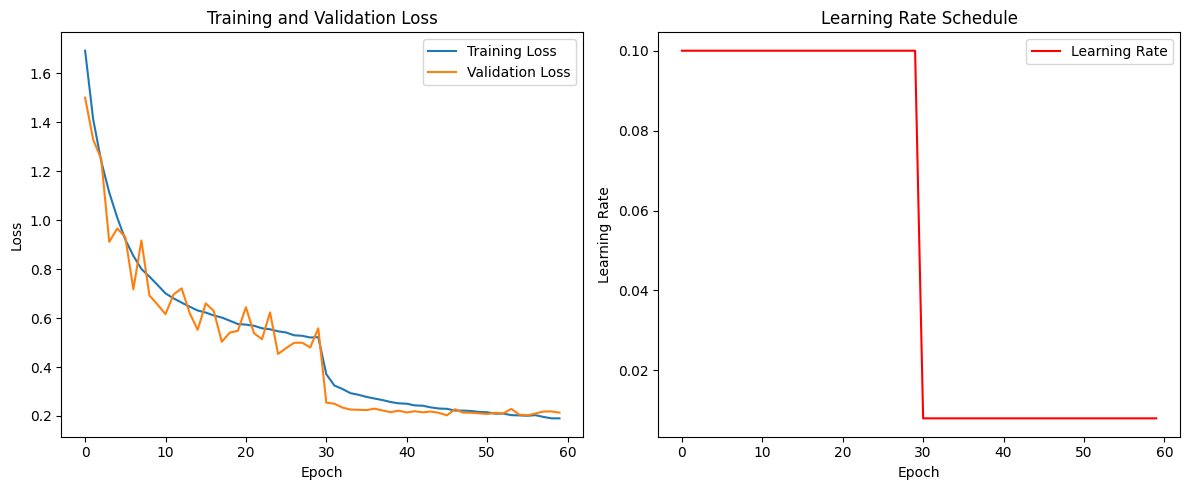

In [10]:
# Plot the loss and learning rate curves
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot learning rate
plt.subplot(1, 2, 2)
plt.plot(learning_rates, label='Learning Rate', color='red')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
# Generate submission file
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        images = batch[0].to(device)  # Get images tensor from tuple and move to device
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

# Generate submission file
submission = pd.DataFrame({'ID': np.arange(len(predictions)), 'Labels': predictions})
submission.to_csv('/kaggle/working/submission5.csv', index=False)
print("Submission1 file saved.")

Submission1 file saved.


###### 